<a href="https://colab.research.google.com/github/kasparvonbeelen/lancaster-newspaper-workshop/blob/wc/BERT_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Machine Learning Workflow
## Or: when the word counts don't work

In this notebook we will cover the followign topics
- Basic elements of the machine learning pipeline, focussing of supervised learning or document classification
- Perform annotations and train a model on this labelled dataset
- Discuss how and when this might be useful
- Disucss limitations and what could be improved


## Install packages

In [ ]:
!pip install -q -U accelerate transformers evaluate datasets
!pip install -q pigeon-jupyter

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00


## Import libraries

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from datasets import Dataset

## Preprocess data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Living-with-machines/ERWT/annotations/HMD_revolution_annotations%20-%20annotations.csv')
df.rename({'label':'category'},axis=1, inplace=True)
df.rename({'answer':'label'},axis=1, inplace=True)
df.replace({'label':{'reject':0, 'accept':1}}, inplace=True)


In [ ]:
df.head(3)

,Unnamed: 0,text,label,KB_answer,meta,_input_hash,_task_hash,category,score,priority,spans,_view_id,_timestamp
0,0,attention of the public.IMPROVEMENT IN STEAM N...,0,reject,"{'date': -3661459200000, 'location': 'Liverpoo...",1367150814,-1818130875,POLITICAL,0.491696,0.491696,[],classification,1661245380
1,1,revolutionists see-ing the hopelessness of suc...,1,accept,"{'date': -3661286400000, 'location': 'Liverpoo...",1497902585,344875813,POLITICAL,0.490497,0.490497,[],classification,1661245387
2,2,"Caleste and Mr. Benjamin Webster, are fulfilli...",1,accept,"{'date': -3666988800000, 'location': 'Liverpoo...",-1754805272,645741434,POLITICAL,0.487390,0.487390,[],classification,1661245402


<Axes: xlabel='label'>

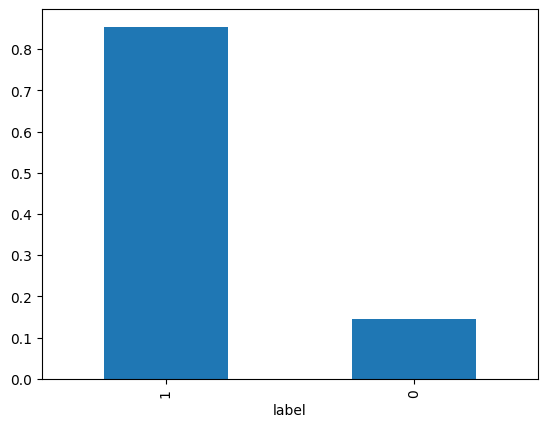

In [ ]:
df.label.value_counts(normalize=True).plot(kind='bar')

## Retrieve data for annotation

In [ ]:
examples_neg = df[df['label']==0].sample(10, random_state=42)
examples_pos = df[df['label']==1].sample(10, random_state=42)
annotation_examples = pd.concat([examples_neg,examples_pos]).sample(frac=1.0)

## Annotate

In [ ]:
from pigeon import annotate
annotations = annotate(
  list(annotation_examples['text']),
  options=['not political', 'political']
)

HTML(value='0 examples annotated, 21 examples left')

Output()

Annotation done.


## Process annotations and create training and evaluation set

In [ ]:
train_df = pd.DataFrame(annotations, columns=['text','label'])
train_df.replace({'label':{'not political':0, 'political':1}}, inplace=True)

In [ ]:
train_df['label'].value_counts()

label
0    10
1    10
Name: count, dtype: int64

In [ ]:
eval_df = df[~df.index.isin(annotation_examples.index)]

In [ ]:
# threshold = int(df.shape[0]*.8)
# train_df = df[['text','labels']][:threshold]
# eval_df = df[['text','labels']][threshold:]
len(df),len(train_df), len(eval_df)

(144, 20, 124)

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

In [ ]:
eval_df['label'].value_counts()

label
1    113
0     11
Name: count, dtype: int64

## Tokenize data

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
      return tokenizer(example["text"], padding=True, max_length=256, truncation=True)

train_tokenized_datasets = train_dataset.map(tokenize_function, batched=True)
eval_tokenized_datasets = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

## Load model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train model

In [ ]:
from transformers import TrainingArguments
import numpy as np
import evaluate

training_args = TrainingArguments(output_dir="test_trainer")


metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
                    output_dir="test_trainer",
                    eval_strategy="epoch",
                    learning_rate=2e-5,
                    per_device_train_batch_size=8,
                    per_device_eval_batch_size=8,
                    seed=32,
                    num_train_epochs=2
                    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=eval_tokenized_datasets,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.469576,0.814516
2,No log,0.478539,0.814516


TrainOutput(global_step=6, training_loss=0.6939603487650553, metrics={'train_runtime': 305.9623, 'train_samples_per_second': 0.131, 'train_steps_per_second': 0.02, 'total_flos': 4069999137600.0, 'train_loss': 0.6939603487650553, 'epoch': 2.0})

## Apply model

In [ ]:
model(**tokenizer('the revolution of the wheel were very fast', return_tensors='pt'))

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1135, -0.0005]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
model(**tokenizer('the glorious revolution', return_tensors='pt'))

SequenceClassifierOutput(loss=None, logits=tensor([[0.0691, 0.0135]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)